In [ ]:
from sklearn.datasets import fetch_openml
# sklearn.datasets have 3 kinds of options fetch_, make_, load_

mnist = fetch_openml('mnist_784', as_frame= False)


In [ ]:
X,y = mnist.data, mnist.target
X.shape
# 70000 images and 28*28 pixels for each of them

(70000, 784)

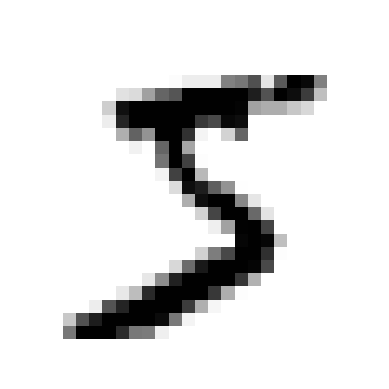

5


In [14]:
import matplotlib.pyplot as plt

def plot_digit(image_data):
    image = image_data.reshape(28,28)
    plt.imshow(image, cmap='binary')
    plt.axis("off")

some_digit = X[0]
plot_digit(some_digit)
plt.show()
print(y[0])

In [15]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]